# Proyecto de investigación: Predicción de lluvia a una hora
## Introducción a la Ciencia de Datos
### Vladimir Garcia Loginova

Para este proyecto se ocupa un dataset que se obtuvo a partir de los datos históricos  de 15 estaciones meteorológicas de la red PEMBU de la UNAM. Los datos consisten en mediciones cada 30 minutos de multiples variables atmosféricas. Los datos se preprocesaorn para conseguir el dataset "limpio" que se ocupa en esta practica. La variable objetivo en este proyecto es "lluvia la siguiente hora", definida como "precip_sig_hora" en el dataset. Se busca encontrar el mejor modelo de clasificación que obtenga el f1 score o recall más alto al predecir la variable objetivo.  El dataset de entrenamiento consiste de 21 años de registros históricos de 2003-2023 para los meses de lluvia (Mayo a Octubre). Mientras que el dataset de prueba consiste de los meses lluviosos del año 2024. 

In [1]:
# importe de pauqterías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score,recall_score,confusion_matrix
import random
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import time
import os
from sklearn.metrics import classification_report
#se define path
path=os.getcwd()

#### Lectura del dataset

In [2]:
df=pd.read_csv("rain_pembu3.csv")
print(df.head(5),df.shape)


  Estacion  Latitud  Longitud  Altitud           Fecha_hora  Temp  Hum_Rel  \
0      CCA  19.3268  -99.1761     2277  2007-05-01 00:00:00   NaN      NaN   
1      CCA  19.3268  -99.1761     2277  2007-05-01 00:30:00   NaN      NaN   
2      CCA  19.3268  -99.1761     2277  2007-05-01 01:00:00   NaN      NaN   
3      CCA  19.3268  -99.1761     2277  2007-05-01 01:30:00   NaN      NaN   
4      CCA  19.3268  -99.1761     2277  2007-05-01 02:00:00   NaN      NaN   

   Rapidez_v_sostenido  Dir_v_sostenido  Rapidez_rachas  Dir_rachas  \
0                  NaN              NaN             NaN         NaN   
1                  NaN              NaN             NaN         NaN   
2                  NaN              NaN             NaN         NaN   
3                  NaN              NaN             NaN         NaN   
4                  NaN              NaN             NaN         NaN   

   Presion_bar  Precipitacion  Rad_Solar  Indice_UV  Precip_sig_hora  
0          NaN            NaN    

Vemos que el dataset tiene un total de 2092068 registros y 16 atributos, donde el ultimo atributo ('Precip_sig_hora') corresponde a la variable obejetivo.

## Limpieza de datos

Vemos cantidad de nan para ver si eliminamos los datos o los dejamos para llenarlos con promedios o medianas.

In [3]:
print(df.isna().sum() )
print(df.shape)

Estacion                    0
Latitud                     0
Longitud                    0
Altitud                     0
Fecha_hora                  0
Temp                   543526
Hum_Rel                509398
Rapidez_v_sostenido    438531
Dir_v_sostenido        735766
Rapidez_rachas         439468
Dir_rachas             752765
Presion_bar            472909
Precipitacion          436596
Rad_Solar              576072
Indice_UV              567173
Precip_sig_hora        437043
dtype: int64
(2653509, 16)


Observamos que mas 10% de los registros tienen nan, por lo que es mejor eliminarlos en este caso

Antes de elimininarse los resgistros, se aprovecha la continuidad de los datos para crear algunas variables de interés de forma eficiente, que consisten del promedio movil de 2 horas previas, para las variables de humedad relativa, rapidez del viento sostenido y rapidez de rachas. La cuales pueden tener una relacion con la variable objetivo.

In [4]:
#primero se convierte a datetime la variable de fechas
df.Fecha_hora=pd.to_datetime(df.Fecha_hora)

def avg_last_2_hours(df_group, columns):
    #  se ordenar el DataFrame por fecha
    df_group = df_group.sort_values('Fecha_hora').reset_index(drop=True)
    df_group['Fecha_hora'] = pd.to_datetime(df_group['Fecha_hora'])  # Asegurar que es de tipo datetime
    df_group = df_group.set_index('Fecha_hora')  # Establecer como índice
    # se calcula el promedio de las últimas 2 horas para cada variable
    for col in columns:
        avg_col_name = f'{col}_2h_mean'
        df_group[avg_col_name] = df_group[col].rolling('2h', closed='right').mean()   
    # Restablecer el índice para devolver la columna 'Fecha_hora' al DataFrame
    df_group = df_group.reset_index()
    return df_group
# Lista de columnas para las que se quiere calcular el promedio de las últimas 2 horas
columns_to_average = ['Hum_Rel', 'Rapidez_v_sostenido', 'Rapidez_rachas']
# se aplica la función por grupo
df0 = df.groupby('Estacion').apply(lambda x: avg_last_2_hours(x, columns_to_average)).reset_index(drop=True)
# Eliminar filas si es necesario (opcional)
df0 = df0.dropna(subset=[f'{col}_2h_mean' for col in columns_to_average])
df0=df0.rename(columns={"Rapidez_v_sostenido_2h_mean": "Rap_v_sos_2h_mean", "Rapidez_rachas_2h_mean": "Rap_rachas_2h_mean"})
print(df0.shape)

/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_4592/447661699.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df0 = df.groupby('Estacion').apply(lambda x: avg_last_2_hours(x, columns_to_average)).reset_index(drop=True)


(2193267, 19)


Ahora si, se eliminan registros nan de las principales variables, que son : Temperatura, humedad relativa, precipitaicon y la variable objetivo precip_sig_hora

In [5]:
df1 = df0.dropna(subset=['Temp', 'Hum_Rel', 'Precipitacion','Precip_sig_hora']).copy()
print(df0.shape, df1.shape)

(2193267, 19) (2087830, 19)


Vemos si existen duplicados

In [6]:
df1_1=df1.drop_duplicates().copy()
print("número de duplicados=",df1.shape[0]-df1_1.shape[0])
print(df1.shape, df1_1.shape)

número de duplicados= 0
(2087830, 19) (2087830, 19)


Vemos que no existen duplicados.

Creamos variables de año, mes y hora para hacer más análisis de limpieza de datos

In [7]:
df1["Año"]=df1.Fecha_hora.dt.year
df1["Mes"]=df1.Fecha_hora.dt.month
df1["Hora"]=df1.Fecha_hora.dt.hour


Eliminamos posibles meses donde por alguna razon no se haya registrado lluvia en ningún día. Para ello primero revisamos por cada estacion año y mes si la suma de la precipitación es igual a cero.

In [8]:
dfp= df1.groupby(['Estacion','Año','Mes'])['Precipitacion'].sum()

for (estacion,año, mes), precipitacion in dfp.items():
    if precipitacion == 0:
        print(f'Estación: {estacion},Año: {año}, Mes: {mes}, Precipitacion: {precipitacion}')

Estación: CCA,Año: 2017, Mes: 10, Precipitacion: 0.0
Estación: CCHA,Año: 2004, Mes: 5, Precipitacion: 0.0
Estación: CCHA,Año: 2008, Mes: 5, Precipitacion: 0.0
Estación: CCHA,Año: 2008, Mes: 6, Precipitacion: 0.0
Estación: CCHA,Año: 2008, Mes: 7, Precipitacion: 0.0
Estación: CCHA,Año: 2008, Mes: 8, Precipitacion: 0.0
Estación: CCHA,Año: 2008, Mes: 9, Precipitacion: 0.0
Estación: CCHA,Año: 2009, Mes: 8, Precipitacion: 0.0
Estación: CCHA,Año: 2010, Mes: 8, Precipitacion: 0.0
Estación: CCHA,Año: 2014, Mes: 10, Precipitacion: 0.0
Estación: CCHA,Año: 2016, Mes: 9, Precipitacion: 0.0
Estación: CCHN,Año: 2008, Mes: 9, Precipitacion: 0.0
Estación: CCHN,Año: 2008, Mes: 10, Precipitacion: 0.0
Estación: CCHN,Año: 2010, Mes: 7, Precipitacion: 0.0
Estación: CCHN,Año: 2010, Mes: 8, Precipitacion: 0.0
Estación: CCHN,Año: 2010, Mes: 9, Precipitacion: 0.0
Estación: CCHN,Año: 2010, Mes: 10, Precipitacion: 0.0
Estación: CCHO,Año: 2006, Mes: 6, Precipitacion: 0.0
Estación: CCHO,Año: 2011, Mes: 9, Precipita

Vemos que si hay muchas estaciones que en varios meses de distintos años  no tienen registros de lluvia, posiblemente por errores de medición o mal procesamiento de los datos. Procedemos a quitar estos registros, ya que pueden generar mucho ruido para la clasificacion.

In [9]:
to_drop = [(estacion, año, mes) for (estacion, año, mes), precipitacion in dfp.items() if precipitacion ==0]
# Filtro para quitar precipitaciones nula o ínfima
df2 = df1[~df1.set_index(['Estacion', 'Año', 'Mes']).index.isin(to_drop)]


## Análisis exploratorio

Revisamos las variables de Temperatura, Humedad_relativa, Precipitacion, Rapidez del viento sostenido y Rapidez de rachas,  que son comunmnte medidas en cualqiuer estacion meteorológica, y que pueden estar asociadas con la precipitación. En este caso, observamos su comportamiento promedio horario.

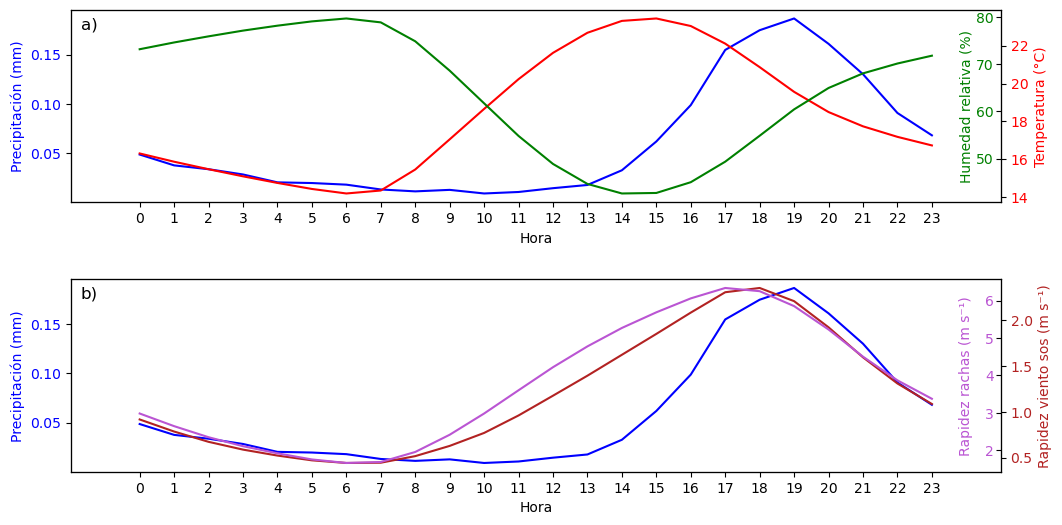

In [10]:
dfm=df2.groupby(["Hora"])[['Temp','Hum_Rel','Precipitacion','Rapidez_v_sostenido','Rapidez_rachas']].mean().reset_index()
var_plots=[['Precipitacion','Temp','Hum_Rel'],['Precipitacion','Rapidez_v_sostenido','Rapidez_rachas']]
names=[['Precipitación','Temperatura','Humedad relativa'],['Precipitación','Rapidez viento sos','Rapidez rachas']]
color=[['blue','red','green'],['blue','firebrick','mediumorchid']]
units=[['mm','°C','%'],['mm','m s⁻¹','m s⁻¹']]
ab=['a','b']

fig=plt.figure(figsize=(12,6))
for i in range(len(var_plots)):

    plt.subplot(2,1,i+1)
    ax=plt.gca()
    ax.plot(dfm.Hora, dfm[var_plots[i][0]], color=color[i][0],label=names[i][0]+"(%s)"%units[i][0])
    ax.set_ylabel(names[i][0]+" (%s)"%units[i][0],color=color[i][0])
    ax.tick_params(axis="y", labelcolor=color[i][0])
    ax2 = ax.twinx()
    ax2.plot(dfm.Hora, dfm[var_plots[i][1]], color=color[i][1],label=names[i][1]+"(%s)"%units[i][1])
    ax2.set_ylabel(names[i][1]+" (%s)"%units[i][1],color=color[i][1])
    ax2.tick_params(axis='y', labelcolor=color[i][1])
    ax3 = ax.twinx()
    ax3.plot(dfm.Hora, dfm[var_plots[i][2]], color=color[i][2],label=names[i][2]+"(%s)"%units[i][2])
    ax3.tick_params(axis="y", labelcolor=color[i][2], direction="in", pad=-5)
    ax3.set_ylabel(names[i][2]+" (%s)"%units[i][2],color=color[i][2],labelpad=-30)
    plt.text(0.02,0.9,ab[i]+')', size=12, weight='normal',ha='center',transform=ax.transAxes)
    plt.setp(ax3.get_yticklabels(), ha="right")
    ax.set_xticks(dfm.Hora)
    ax.set_xlabel("Hora")
    plt.xlim(-2,25)
    #plt.ylim(0,2.5)
    #plt.tight_layout()
    #ax.set_title("%s y %s horaria promedio"%(names[i][0],names[i][1]),fontsize=10)
plt.subplots_adjust(hspace=0.4)#hspace=0)
fig_name='figura_vars_prom.png'
plt.savefig(path+'/figuras/%s'%fig_name,dpi=300,facecolor='white',bbox_inches='tight')
plt.show()
print("")


Podemos ver que la mayoría de la precipitacion sucede entre las 13 y las 23 horas, con un pico a las 19 h, evidenciando que la lluvia sucede principalmente por las tardes. En ese sentido, si bien no es explicita la relacion de la preciptiación con la temperatura y la humedad relativa, podemoste ver que la humedad relativa incrementa por la tarde, desde las 2 pm, y que la temperatura empieza a descender a la misma hora. Siendo esta combinacion de hechos un factor que ayuda a generar la lluvia. Por otra parte , se observa que la rapidez del viento (tanto sostenido como en rachas) tiene un patrón ligeramente distinto, incrementando desde las 7 am, con un pico a las 5-6 pm, muy cercano al pico de la precipitación. Esto último también puede tener alguna relación con la precipitación.

Ahora revisamos las proporciones entre dias con lluvia y sin lluvia, ya que posiblemente hay un desbalance entre ambos.

Registros sin lluvia: 1908650
Registros con lluvia: 96804
Relación lluvia / no-lluvia 19.72


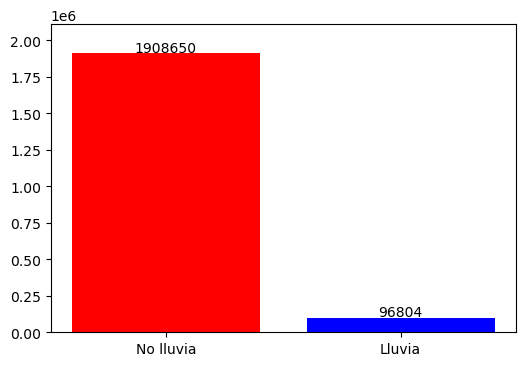

In [11]:
registros_sin_lluvia=df2.loc[df2['Precipitacion'] == 0,'Precipitacion'].shape[0]
registros_con_lluvia=df2.loc[df2['Precipitacion'] > 0,'Precipitacion'].shape[0]
print("Registros sin lluvia:",int(round(registros_sin_lluvia,0)))
print("Registros con lluvia:",int(round(registros_con_lluvia,0)))
print("Relación lluvia / no-lluvia",round(registros_sin_lluvia/registros_con_lluvia,2))
int_rsl=int(round(registros_sin_lluvia,0))
int_rcl=int(round(registros_con_lluvia,0))
                  
fig=plt.figure(figsize=(6,4))
plt.bar(['No lluvia','Lluvia'],[registros_sin_lluvia,registros_con_lluvia],color=['red','blue'])
plt.text( 0,int_rsl+40000,int_rsl, ha='center', va='center')
plt.text( 1,int_rcl+40000,int_rcl, ha='center', va='center')
plt.ylim(0,int_rsl+2e5)
fig_name='figura_lluvia_no_lluvia.png'
plt.savefig(path+'/figuras/%s'%fig_name,dpi=300,facecolor='white',bbox_inches='tight')
plt.show()


Vemos que existen 19 veces mas registros de no lluvia que de lluvia. Es decir un dataset muy desbalanceado.

In [12]:
df_no_rain_vars=df2.loc[df2['Precipitacion'] == 0,['Hora','Temp','Hum_Rel','Rapidez_v_sostenido','Rapidez_rachas']]
df_si_rain_vars=df2.loc[df2['Precipitacion'] >  0,['Hora','Temp','Hum_Rel','Rapidez_v_sostenido','Rapidez_rachas']]
print('no rain')
print(df_no_rain_vars.iloc[:,1:].mean().round(2))
print('rain')
print(df_si_rain_vars.iloc[:,1:].mean().round(2))

no rain
Temp                   18.43
Hum_Rel                63.05
Rapidez_v_sostenido     1.19
Rapidez_rachas          3.71
dtype: float64
rain
Temp                   15.90
Hum_Rel                84.25
Rapidez_v_sostenido     1.42
Rapidez_rachas          4.32
dtype: float64


Podemos ver que todas las variables analizadas si muestran una relacion respecto a los registros de lluvia o no lluvia. Para los registros de lluvia la temperatura decrece, la humedad relativa aumenta, y la rapidez del vientos incrementa tambien. Con los registros de no lluvia sucede lo contrario.

Hacemos un paiplot con una muestra del dataset para ver las relaciones con diversas variables y separandolos por la variable objetivo

<Figure size 600x400 with 0 Axes>

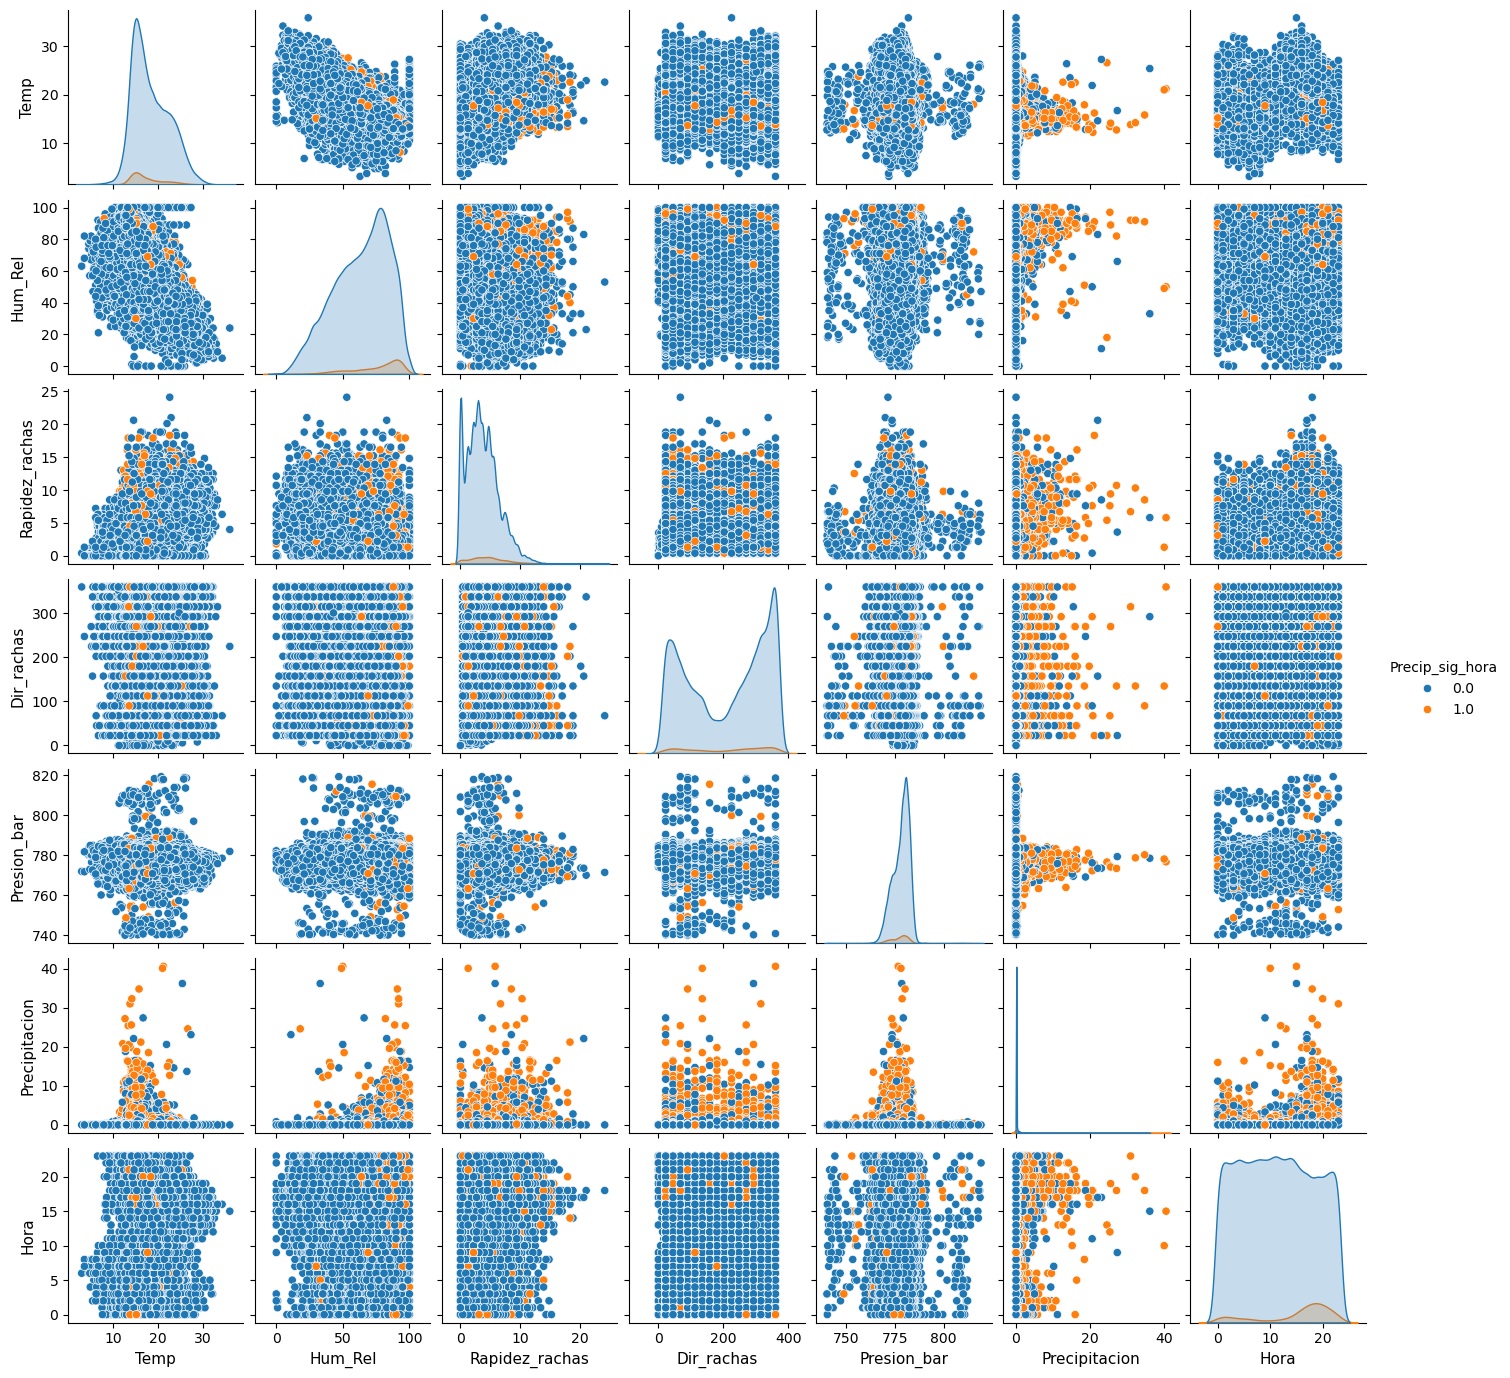

In [47]:
df_pp=df2.loc[:,['Temp', 'Hum_Rel', 'Rapidez_rachas','Dir_rachas',\
                 'Presion_bar','Precipitacion','Precip_sig_hora', 'Hora']].sample(frac=0.05)
plt.figure(figsize=(6,4))
g=sns.pairplot(df_pp, hue='Precip_sig_hora',height=2)
for label in g.axes.flatten():
    label.set_xlabel(label.get_xlabel(), fontsize=11)
    label.set_ylabel(label.get_ylabel(), fontsize=11)
g.tight_layout()
fig_name='figura_pairplot.png'
plt.savefig(path+'/figuras/%s'%fig_name,dpi=300,facecolor='white',bbox_inches='tight')
plt.show()

Se observa una ligera relacion incremental entre la variable de precipitacion y la humedad relativa. También se nota como la humedad relativa decrece conforme la temperatura aumenta. Lo anterior corrobora los análisis hechos previamente. Las demás variables no muestran una relación clara entre ellas.

Respecto a la variable objetivo. Se observa una ligera diferencia entre clases , principalmente  en las variable de humedad relativa, rapidez rachas, direccion de rachas, precipitación y hora.

## Aumento y extracción de características

#### Obtenemos algunas variables de interés.

La lluvia sucede principalmente en la tarde, por lo que hacemos una separación entre mañana (antes del medio día) y tarde (después del medio día).

Obtenemos variable binaria (0 o 1) sobre si llovió o no en cada registro.

Hacemos una variable  de timestamp de las fechas, que puede ser util para la clasificiación.

Convertimos el nombre de la estacion a variable númerica.

In [13]:
df2_1=df2.copy()
df2_1['Mañana_tarde'] = np.select([df2_1['Hora'] < 12, df2_1['Hora'] >= 12], [0,1])
df2_1["Precip_ahora"]=np.select([df2_1['Precipitacion'] > 0 ],[1],default=0)
df2_1['time_stamp'] = df2_1.Fecha_hora.values.astype(np.int64) // 10 ** 9


le = LabelEncoder()
st_num=le.fit_transform(df2_1.Estacion.values)
df2_1=df2_1.assign(Est_num=st_num)

print(df2_1.shape)

(2005454, 26)


Un par de variables útiles son saber si llovió una hora o dos horas antes, esto puede ayudar a los modelos a saber si continuará lloviendo.
Se crean estas variables.

In [14]:

for i in range(1,3):
    def rain_prev_hour(df_group):
        #  se ordena el df por la columna de fechas
        df_group = df_group.sort_values('Fecha_hora').reset_index(drop=True)
        
        # se crea un df desplazado para simular la siguiente hora
        df_prev = df_group.copy()
        df_prev['Fecha_hora'] += pd.Timedelta(hours=i)  # Restar una hora en df_next
    
        # se realiza el merge del df original con el desplazado
        merged = pd.merge(df_group, df_prev[['Fecha_hora', 'Precipitacion']], 
                          on='Fecha_hora', suffixes=('', '_prev'), how='left')
        
        # creamos la columna 'Precip_sig_hora' para indicar si llovió en la siguiente hora
        merged['Precip_ant_%shora'%(i)] = (merged['Precipitacion_prev'] > 0).apply(lambda x: 1 if x > 0 else (0 if pd.notna(x) else pd.NA))
        
        # el output es un df con la nueva columna, eliminando columnas no deseadas
        return merged.drop(columns=['Precipitacion_prev'])
    
    # Aplicar la función a cada grupo y resetear el índice
    #df2_1 = df2_0.groupby('Estacion').apply(rain_prev_hour).reset_index(drop=True)
    df2_1 = df2_1.groupby(['Estacion',pd.PeriodIndex(df2['Fecha_hora'], freq="Y")]).apply(rain_prev_hour).reset_index(drop=True)
#df2_0 = dfs.groupby(['Estacion', pd.PeriodIndex(dfs['Fecha_hora'], freq="Y")]).apply(rain_next_hour).reset_index(drop=True)

# df resultante
df3 = df2_1.dropna(subset=['Precip_ant_1hora','Precip_ant_2hora'])
print(df3.shape)

/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_4592/3558319024.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2_1 = df2_1.groupby(['Estacion',pd.PeriodIndex(df2['Fecha_hora'], freq="Y")]).apply(rain_prev_hour).reset_index(drop=True)


(2005454, 28)


/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_4592/3558319024.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2_1 = df2_1.groupby(['Estacion',pd.PeriodIndex(df2['Fecha_hora'], freq="Y")]).apply(rain_prev_hour).reset_index(drop=True)


### Mas limpieza de datos, enfocada al balanceo de de clases de lluvia - no lluvia

Se limpian aun mas los datos, encontrando los periodos con registros de no lluvia mayores a 10 dias seguidos, para acotarlos a ese numero de dias, eliminando todos los registros fuera de este rango.

In [15]:
suma=0
maxl=[]
index_df_delete=[]
for s in df3.Estacion.unique():
    suma+=1
    if suma :
        print(s)
        for y in df3.loc[df3.Estacion==s,'Fecha_hora'].dt.year.unique():

            df_st=df3.loc[(df3.Estacion==s) & (df3.Fecha_hora.dt.year == y),:]
            diffs = np.diff(df_st.Precip_ahora.values)
        
            # se identifican los inicios y finales de cada secuencia de '1's
            starts = np.where(diffs == 1)[0]+1  # índice donde empieza cada secuencia de '1's
            ends = np.where(diffs == -1)[0]+1 
            # lista con los inicios y fin de los unos
            ones_edges=list(zip(starts, ends))
            lista=[]
            # se indexean correctamente los rangos con puros 0's dentro, considerando
            # tanto el inicio como el fin de los arrays
            for idx,j in enumerate(ones_edges):
                if idx == 0:
                    inr=[0,j[0]]
                    count=j[0]
                elif idx == len(ones_edges)-1:
                    inr=[j[1],len(df_st.Precip_ahora.values)]
                    count=len(df_st.Precip_ahora.values)-j[1]
                else:
                    inr=[j[1],ones_edges[idx+1][0]]
                    count=ones_edges[idx+1][0]-j[1]

                hours_no_rain=round(count/2,2)
                days_no_rain=round(count/2/24,2)

                #se acotan los periodos de no lluvia a que no sean mayores a 5 dias
                if days_no_rain >10:

                    range_no_rain=np.arange(inr[0]+240,inr[1]-240+1).astype(int)

                    index_df_del=df_st.Precip_ahora.iloc[range_no_rain].index.values

                    index_df_delete.append(index_df_del)

index_df_delete_f=np.hstack(index_df_delete)
df4=df3.drop(index_df_delete_f)
print(df4.shape,df3.shape)

CCA
CCHA
CCHN
CCHO
CCHS
CCHV
ENP1
ENP2
ENP3
ENP4
ENP5
ENP6
ENP7
ENP8
ENP9
(1877732, 28) (2005454, 28)


Se hace un ultimo balance a los datos, para mejorar las proprociones de dias con lluvia y no lluvia. En este caso se eliminan de forma aleatoria el 40% de los datos de no lluvia. Se encontro que este procentaje es adecuado para no perder generalidad en los datos, pero a su vez permitir que esten mas balanceadas las 2 clases.

Registros sin lluvia: 1029838
Registros con lluvia: 96802
Relación lluvia / no-lluvia 10.64


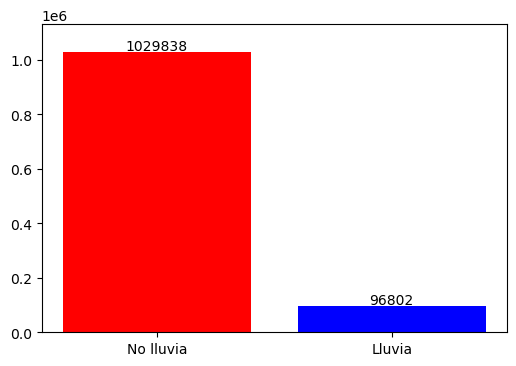

In [16]:
n_delete = int(df4.shape[0]*0.4)
#indices que se quitan de forma aleatoria
ind_delete = df4[(df4['Precip_ahora']==0) ].sample(n=n_delete).index
df5 = df4.drop(ind_delete)

#volvemos a imprimir los registros d elluvia y no lluvia
registros_sin_lluvia=df5.loc[df5['Precip_ahora'] == 0,'Precip_ahora'].shape[0]
registros_con_lluvia=df5.loc[df5['Precip_ahora'] == 1,'Precip_ahora'].shape[0]
print("Registros sin lluvia:",int(round(registros_sin_lluvia,0)))
print("Registros con lluvia:",int(round(registros_con_lluvia,0)))
print("Relación lluvia / no-lluvia",round(registros_sin_lluvia/registros_con_lluvia,2))
int_rsl=int(round(registros_sin_lluvia,0))
int_rcl=int(round(registros_con_lluvia,0))
                  
fig=plt.figure(figsize=(6,4))
plt.bar(['No lluvia','Lluvia'],[registros_sin_lluvia,registros_con_lluvia],color=['red','blue'])
plt.text( 0,int_rsl+20000,int_rsl, ha='center', va='center')
plt.text( 1,int_rcl+20000,int_rcl, ha='center', va='center')
plt.ylim(0,int_rsl+1e5)
fig_name='figura_lluvia_no_lluvia2.png'
plt.savefig(path+'/figuras/%s'%fig_name,dpi=300,facecolor='white',bbox_inches='tight')
plt.show()

Eliminamos valores nan para empezar a preparar el dataset para el analisis de correlacion y los modelos de clasificacion.

In [17]:
df6=df5.dropna()
print(df5.shape,df4.shape)

(1126640, 28) (1877732, 28)


Vemos matriz de correlacion para ver posibles asociaciones y ver con que variables nos conviene quedarnos

['Temp' 'Hum_Rel' 'Rapidez_v_sostenido' 'Dir_v_sostenido' 'Rapidez_rachas'
 'Dir_rachas' 'Presion_bar' 'Precipitacion' 'Rad_Solar' 'Indice_UV'
 'Precip_sig_hora' 'Hum_Rel_2h_mean' 'Rap_v_sos_2h_mean'
 'Rap_rachas_2h_mean' 'Año' 'Mes' 'Hora' 'Mañana_tarde' 'Precip_ahora'
 'time_stamp' 'Est_num' 'Precip_ant_1hora' 'Precip_ant_2hora']


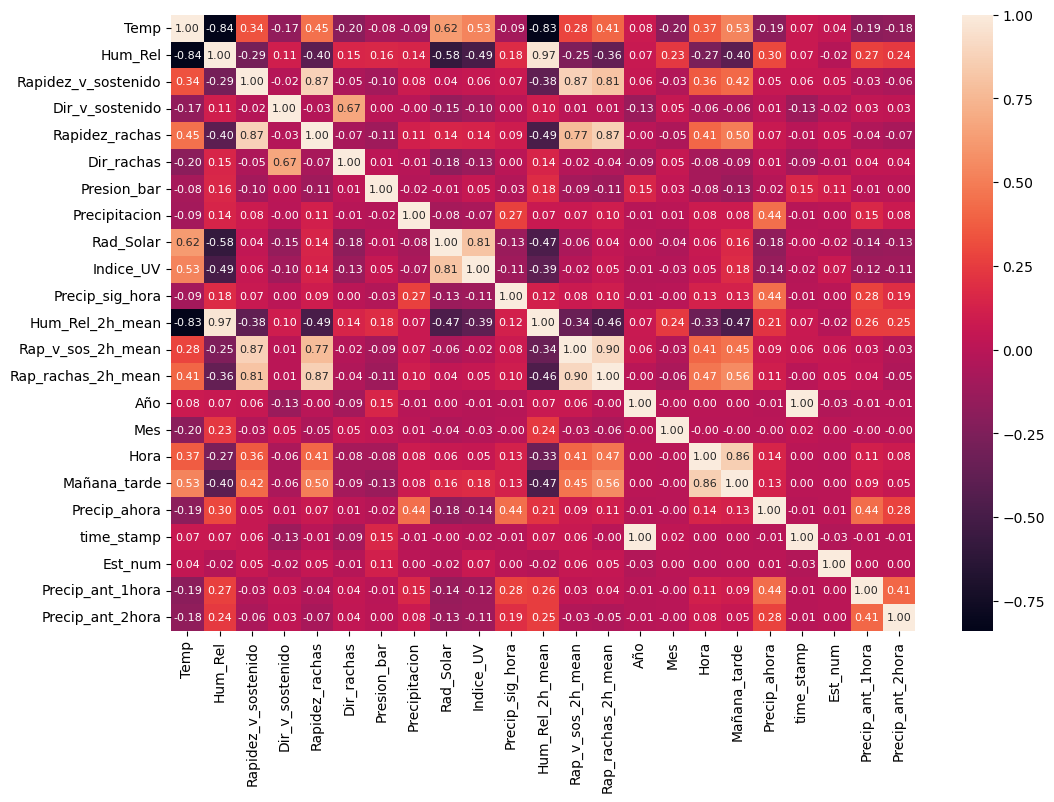

In [18]:
df_corr=df6.drop(columns=['Estacion','Fecha_hora','Latitud','Longitud','Altitud'])
corr_mat = df_corr.corr() 
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat, annot = True,annot_kws={"size": 8},fmt='.2f')
fig_name='figura_correlacion.png'
plt.savefig(path+'/figuras/%s'%fig_name,dpi=300,facecolor='white',bbox_inches='tight')
print(df_corr.columns.values)

En la matriz de correlacion se observan diversas variables que tienen  alguna relación con la variable objetvo "Precip_sig_hora". La variable binaria de precipitacion presente o ausente "Precip_ahora" es la mas correlacionada (con un valor de 0.44), seguidamente esta la variablde de precipitación a 1 hora en el pasado "Precip_ant_1hora". Curiosamente esta variable tiene mejor correlacion que la de Precipitación, que es la siguiente variable con mayor precipitacion, ambas tienen una correlacion de 0.28 y 0.27, respectivamente.
Precipitación a 2 horas en el pasado "Precip_ant_1hora" es la siguiente variable mayor correlacionada, seguida de la Humedad relativa, ambas variable tienen una correlacion de 0.19 y 0.18, respectivamente. Estas correlaciones son consistentes con lo visto en el análisis explortorio, dodne se vio que el promedio de la humedad relativa y el viento si cambiaba segun fueran dias con lluvia o sin lluvia.

Las variabless de fecha "Hora" y "Mañana_tarde", tambien alcanzaron cierta correlacion con valores de 0.13 ambas.

Los promedio moviles a 2 horas en el pasado de las varibales de Humedad Relativa, Rapidez de rachas y Rapidez del viento sostenido, también mostraroon correlacion con valores de 0.12, 0.10 y 0.8, respectivamente.

A pesar de que muchas variables representaban buena correlacion con la variable objetivo, mediante pruebas se encontro que dejar algunas de ellas empeoraban la clasifiación de los modelos, por ejemplo, estos casos fueron  para los promedios moviles de la variables  de la rapidez del viento. De hecho también se buscó usar el promedio movil de la temperatura, pero este se descartó tempranamente por su correlacion negativa con la variable objetivo.

Para la ANN inclusive se tuvieron que quitar las variables de fecha, ya que sesgaban mucho el modelo hacia la clase de "no lluvia la siguiente hora".

Se preparan las variables X y y para obtener los conjuntos de entrenamiento y prueba.

In [19]:
target=df6.Precip_sig_hora
X=df6.drop(columns=['Precip_sig_hora','Estacion','Fecha_hora','Latitud','Longitud','Altitud','Presion_bar',\
                    'Rap_v_sos_2h_mean','Rap_rachas_2h_mean'])
y=target

#### Reduccion de dimensionalidad
Se ocupa RD para algunos modelos de clasifiación como KNN, para hacerlos más eficientes.

In [20]:
# Se usa PCA y LDA
X_PCA = PCA(n_components=5).fit_transform(X)
X_LDA = LDA(n_components=1).fit_transform(X,y)


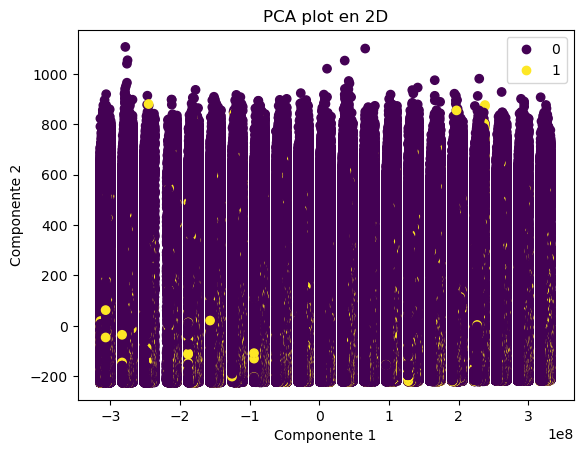

In [48]:
scatter = plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y)
plt.title('PCA plot en 2D')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(*scatter.legend_elements())
plt.show()

La redcucción de dimensionalidad con PCA no muestra alguna clasificación.

Se prepara los datsaets de entrenamiento

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_rd, X_test_rd, y_train_rd, y_test_rd = train_test_split(X_LDA, y, test_size=0.2, random_state=42)

## Modelos de clasificación

### Modelos de SL

Se crea función que va a ejecutar los modelos y calcular los estadísticos

In [22]:

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name,f1_scores,recall_scores,cms,times,y_predict):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    total_time = round(end_time - start_time,4)
    #y_predict_train = model.predict(X_train)
    y_predict_test = model.predict(X_test) 
    #f1_train=f1_score(y_train, y_predict_train, average='macro')
    f1_test=f1_score(y_test, y_predict_test, average='macro')
    # Sensibilidad
    recall_test=recall_score(y_test, y_predict_test, average='macro')
    # Matriz de confusion
    cm= confusion_matrix(y_test, y_predict_test)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    
    # Especificidad (TNR)
    TNR_test= TN/(TN+FP)
    class_counts = np.sum(cm, axis=1)
    TNR_test_global = np.sum(TNR_test * class_counts) / np.sum(class_counts)


    f1_scores.append(f1_test)
    recall_scores.append(recall_test)
    cms.append(cm)
    times.append(total_time)
    y_predict.append(y_predict_test)

    print(f'Model: {model_name}')
    print(f'Test f1: {f1_test:.4f}')
    print(f'Test recall: {recall_test:.4f}')
    #print('Test TNR:', TNR_test.round(4))
    print(f'Test TNR: {TNR_test_global:.4f}')
    print("Tiempo de ejecución:",total_time)
    print("")

Se cargan paqueterías de los modelos

In [23]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier


Se implementan los modelos

In [24]:
#Clasicos
#Naive-Bayes
GNB=GaussianNB()
#C4.5 (Decision Tree)
CDT=DecisionTreeClassifier()
## Con los siguientes modelos se usa reduccion de dimensionalidad
#k-Nearest Neighbors
KNC=KNeighborsClassifier(n_neighbors=20)

#Ensambles
#Balanced Bagging
BBC=BalancedBaggingClassifier()
# Random Forest Classifier
RFC=RandomForestClassifier()
#Adaboost Classifier
ABC=AdaBoostClassifier()
#CatBoost Clasifier
CBC=CatBoostClassifier(verbose=False)

models_train=[BBC,RFC,ABC,CBC,GNB,CDT,KNC]#,LGR]
models_name_train=['Balanced Bagging','Random Forest','Adaboost','CatBoost',\
            'Naive Bayes','C4.5','KNN']#,'Logistic Regression']

f1_scores_train=[]
recall_scores_train=[]
cms_train=[]
times_train=[]
y_predict_model=[]

for i in range(len(models_train[:])):
    # modelos que ocupan RD, en este caso KNN
    if i == len(models_train)-1:
        evaluate_model(models_train[i], X_train_rd, X_test_rd, y_train_rd, y_test_rd, models_name_train[i],\
                       f1_scores_train,recall_scores_train,cms_train,times_train,y_predict_model)
    # en los demas casos se utiliza el dataset normal
    else:
        evaluate_model(models_train[i], X_train, X_test, y_train, y_test, models_name_train[i],\
                       f1_scores_train,recall_scores_train,cms_train,times_train,y_predict_model)




Model: Balanced Bagging
Test f1: 0.6761
Test recall: 0.7944
Test TNR: 0.7169
Tiempo de ejecución: 7.8285

Model: Random Forest
Test f1: 0.6842
Test recall: 0.6385
Test TNR: 0.3352
Tiempo de ejecución: 84.7273



/Users/vcx/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: Adaboost
Test f1: 0.6653
Test recall: 0.6312
Test TNR: 0.3278
Tiempo de ejecución: 18.0696

Model: CatBoost
Test f1: 0.6893
Test recall: 0.6438
Test TNR: 0.3454
Tiempo de ejecución: 26.2845

Model: Naive Bayes
Test f1: 0.4827
Test recall: 0.5000
Test TNR: 0.0669
Tiempo de ejecución: 0.1177

Model: C4.5
Test f1: 0.6478
Test recall: 0.6546
Test TNR: 0.4010
Tiempo de ejecución: 5.6466

Model: KNN
Test f1: 0.6254
Test recall: 0.5911
Test TNR: 0.2473
Tiempo de ejecución: 0.1333



Para los modelos de tipo ensamble, podemos ver que, a pesar de que tienen un F1_score mayor a 0.66, no son los que tienen el recall más lto. En cambio el modelo de Balance Bagging es el muestra el mayor recall, debido a que tiene el mayor número de verdaderos positivos acertados, tal como se ve mas adelante en la matriz de confusión. Los modelos clásicos muestran un mal desempeño en general, con excepeción de C4.5.

In [25]:
print("Mejores modelos recall, f1 score y  tiempo de ejecución")
print("")
index_scores_train=np.argsort(recall_scores_train)[::-1]
for i in index_scores_train:
    print("%s:"%models_name_train[i], round(recall_scores_train[i],4), round(f1_scores_train[i],4), round(times_train[i],2))

f1s_round=[round(i,4) for i in f1_scores_train]
rcs_round=[round(i,4) for i in recall_scores_train]

Mejores modelos recall, f1 score y  tiempo de ejecución

Balanced Bagging: 0.7944 0.6761 7.83
C4.5: 0.6546 0.6478 5.65
CatBoost: 0.6438 0.6893 26.28
Random Forest: 0.6385 0.6842 84.73
Adaboost: 0.6312 0.6653 18.07
KNN: 0.5911 0.6254 0.13
Naive Bayes: 0.5 0.4827 0.12


Se ordenan los modelos de mejor a peor, usando la métrica recall, ya que permite ver que modelos obtuvieron la mayor cantidad de positivos verdaderos, que es lo que más nos interesa. Es posible ver que, los modelos con mejor F1 score no necesariamente tienen el mejor recall.

#### Más adelante se grafican la matrices de confusión de los modelos de SL junto a la matriz de la ANN.

### Redes Neuronales Artificiales (ANN)

Preparamos datasets para ANN.
Se eliminan variables de tiempo, ya que sesgan el modelo. También se quitn otras variables no útiles.

In [26]:
columns_drop_ANN=['Año','Mes','Mañana_tarde','time_stamp','Hora','Rad_Solar','Indice_UV']
X_train_ANN=X_train.drop(columns=columns_drop_ANN)
X_test_ANN=X_test.drop(columns=columns_drop_ANN)

Se importan las paqueterias para implementar las ANN

In [27]:
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

Se utiliza una ANN de tipo secuencial con 1 capa de entrada, 4 capas ocultas y 1 de salida.

In [28]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Inicialización the NN
model_ANN = Sequential() 

# layers
model_ANN.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_test_ANN.shape[1]))
model_ANN.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model_ANN.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model_ANN.add(Dropout(0.25))
model_ANN.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model_ANN.add(Dropout(0.5))
model_ANN.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiando la ANN
opt = Adam(learning_rate=0.00009)
model_ANN.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train del  ANN
class_weights = {0: 1, 1: 5}  # se aumenta el peso de la clase minoritaria
#Con 20 epocas es suficiente ya que son pocos datos.
history = model_ANN.fit(X_train_ANN, y_train.values, batch_size=32, epochs=20, callbacks=[early_stopping],\
                        validation_split=0.2, class_weight=class_weights)

Epoch 1/20


/Users/vcx/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19494/19494 ━━━━━━━━━━━━━━━━━━━━ 6s 273us/step - accuracy: 0.9308 - loss: 0.7130 - val_accuracy: 0.9190 - val_loss: 0.2521
Epoch 2/20
19494/19494 ━━━━━━━━━━━━━━━━━━━━ 5s 271us/step - accuracy: 0.9201 - loss: 0.5755 - val_accuracy: 0.9089 - val_loss: 0.2772
Epoch 3/20
19494/19494 ━━━━━━━━━━━━━━━━━━━━ 5s 271us/step - accuracy: 0.9213 - loss: 0.5674 - val_accuracy: 0.9096 - val_loss: 0.2740
Epoch 4/20
19494/19494 ━━━━━━━━━━━━━━━━━━━━ 5s 271us/step - accuracy: 0.9207 - loss: 0.5607 - val_accuracy: 0.9186 - val_loss: 0.2379
Epoch 5/20
19494/19494 ━━━━━━━━━━━━━━━━━━━━ 5s 271us/step - accuracy: 0.9218 - loss: 0.5600 - val_accuracy: 0.9167 - val_loss: 0.2428
Epoch 6/20
19494/19494 ━━━━━━━━━━━━━━━━━━━━ 5s 271us/step - accuracy: 0.9208 - loss: 0.5592 - val_accuracy: 0.9099 - val_loss: 0.2666
Epoch 7/20
19494/19494 ━━━━━━━━━━━━━━━━━━━━ 5s 271us/step - accuracy: 0.9206 - loss: 0.5558 - val_accuracy: 0.9143 - val_loss: 0.2492
Epoch 8/20
19494/19494 ━━━━━━━━━━━━━━━━━━━━ 5s 272us/step - accuracy: 0.9

Observamos la perdida (loss) del entrenamiento y la validacion por época en una grafica.

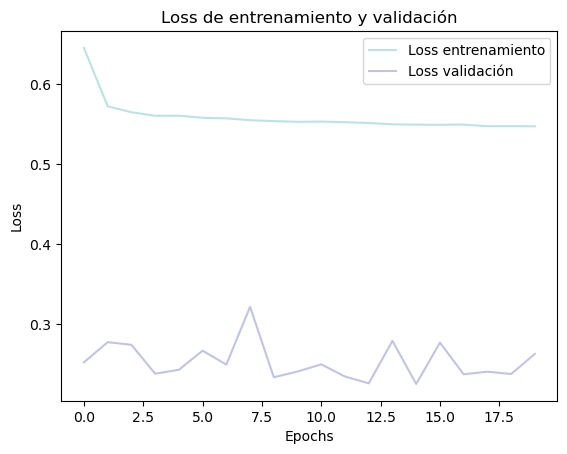

In [29]:
history_df = pd.DataFrame(history.history)


plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Loss entrenamiento')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Loss validación')
plt.title('Loss de entrenamiento y validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
fig_name='figura_loss_epochs_ANN.png'
plt.savefig(path+'/figuras/%s'%fig_name,dpi=300,facecolor='white',bbox_inches='tight')

plt.show()

El hecho de que haya picos y valles es debido a la penalizacion por los pesos, donde se busca que haya mayor penalización hacia la clase mayoritaria.

#### Hacemos las prediccion

In [30]:
# Predicting the test set results
y_predict_test_ANN = model_ANN.predict(X_test_ANN)
y_predict_test_ANN = (y_predict_test_ANN > 0.5)

6092/6092 ━━━━━━━━━━━━━━━━━━━━ 1s 167us/step


### Matrices de confusión del entrenamiento de modelos de SL y ANN

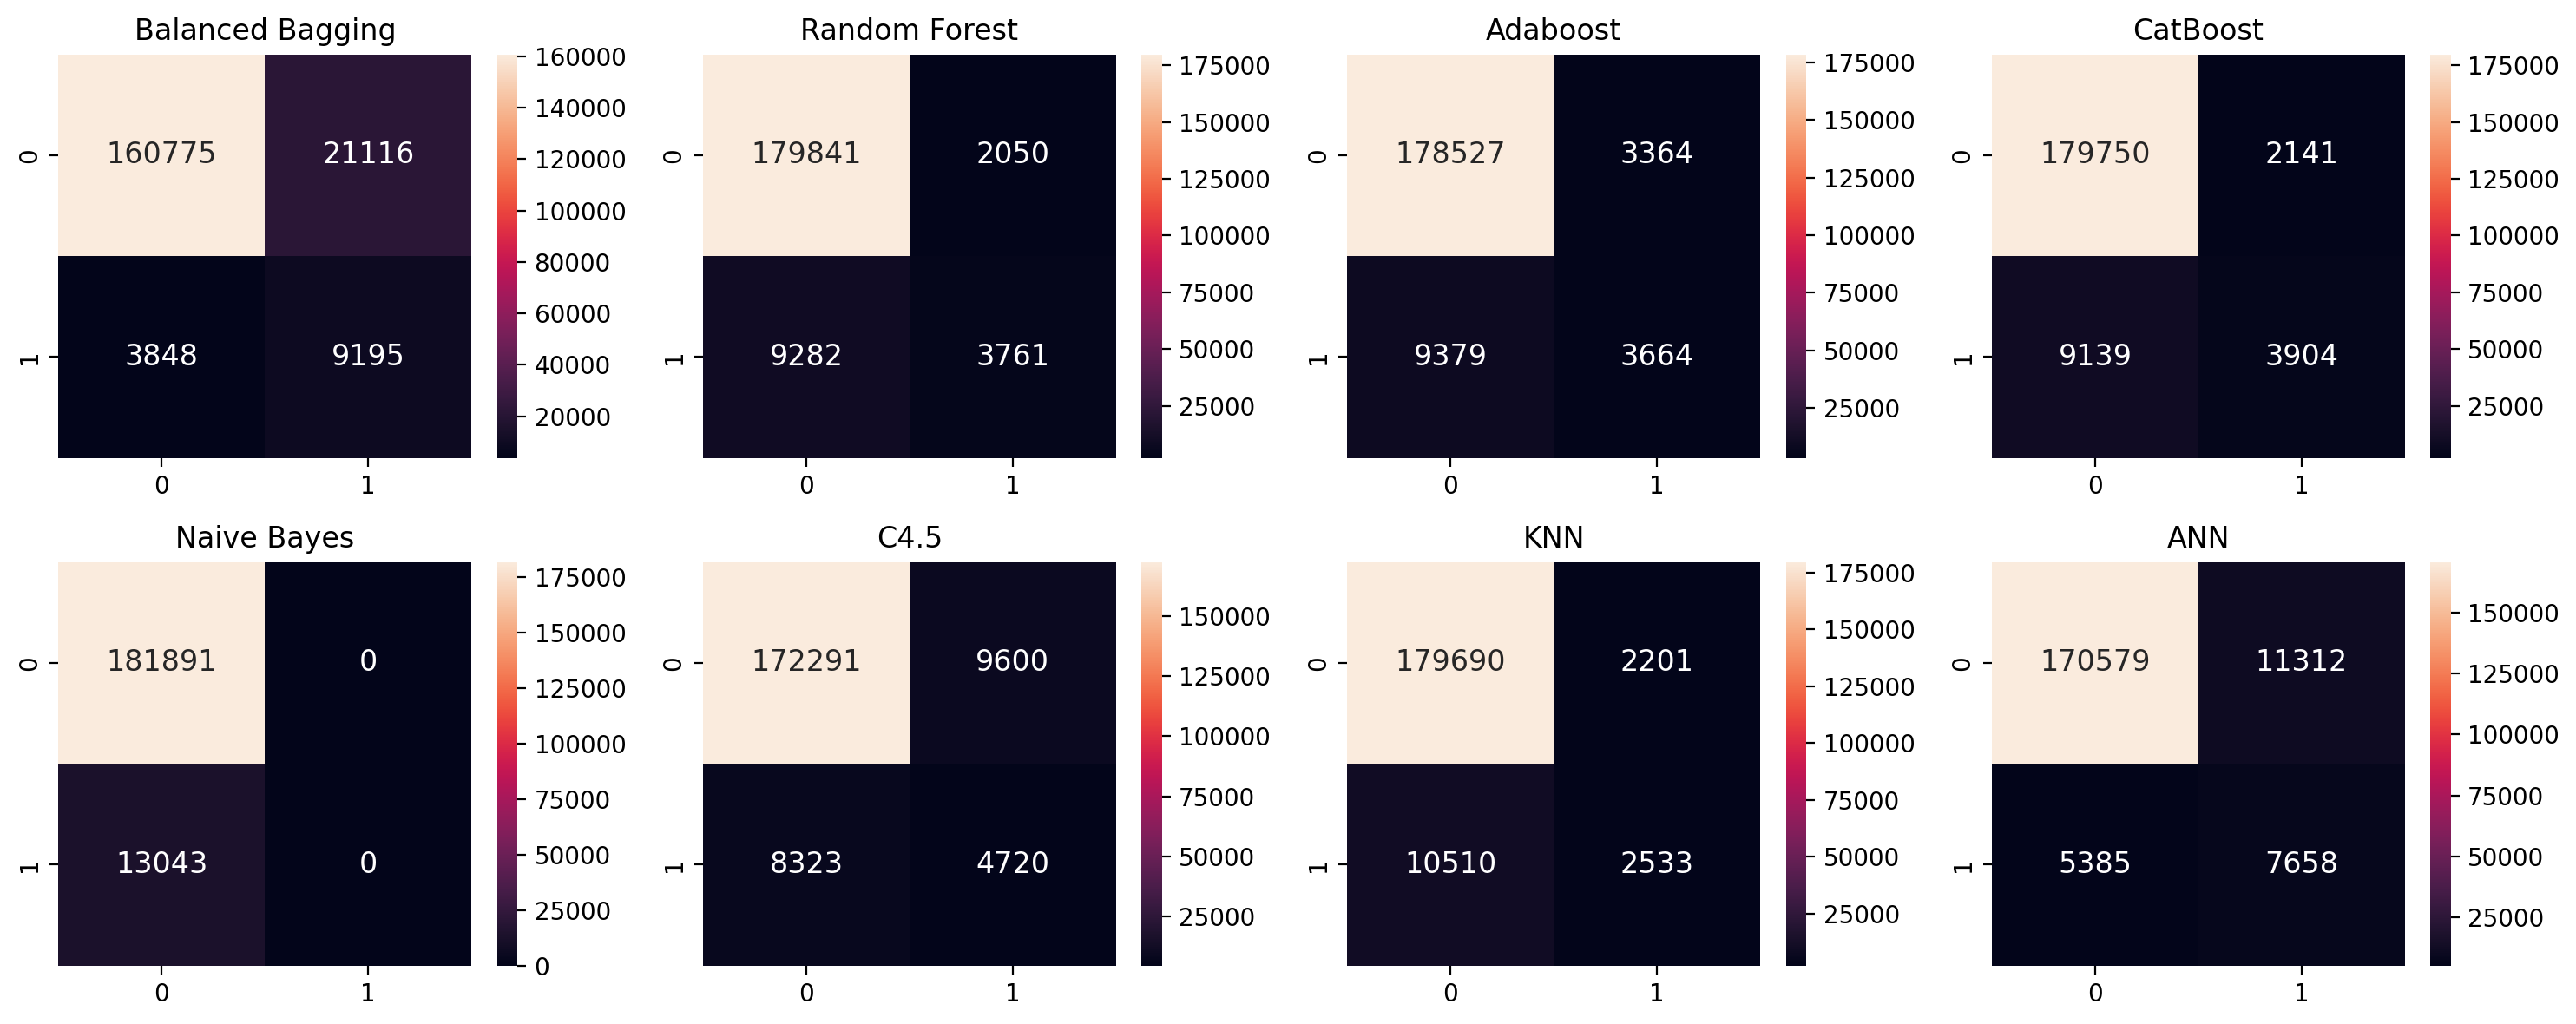

In [31]:
f1_ann=f1_score(y_test, y_predict_test_ANN, average='macro')
recall_ann=recall_score(y_test, y_predict_test_ANN, average='macro')

cm_ann= confusion_matrix(y_test, y_predict_test_ANN)
if len(cms_train) < 8:
    cms_train.append(cm_ann)
    f1s_round.append(round(f1_ann,4))
    rcs_round.append(round(recall_ann,4))
    models_name_train.append('ANN')

fig = plt.figure(figsize=(15,6),dpi=200)
for i in range(len(cms_train[:])):
    plt.subplot(2,4,i+1)
    sns.heatmap(cms_train[i], annot=True,annot_kws={"size":12},fmt='.0f')
    plt.title(models_name_train[i])
plt.tight_layout()
fig_name='figura_cm_SL_train.png'
plt.savefig(path+'/figuras/%s'%fig_name,dpi=300,facecolor='white',bbox_inches='tight')


Como se vio en las métricas de los modelos de SL, solamente el modelo de Balanced Bagging (BB) logra predecir con mayor acierto la clase 1 (si-lluvia la siguiente hora), esto lo logra con el costo de predecir un gran número de falsos positivos. El siguiente modelo de SL que mejor predice los verdaderos positivos es el árbol de decisión C4.5. Para ambos modelos BB y C4.5, este resultado es consistente con su métrica de recall, ya que tienen los valores más altos entre los modelos SL. Los siguientes modelos con más positivos verdaderos son CatBoost, AdaBoost y Random Forest, con valores mayores a 3500. KNN tiene ub desempeño bastante modesto, mientra qiue Naive Bayes no logra predcir ningún valor positivo.

La ANN es quien presenta los mejores resultados entre todos los modelos de ML, en el sentido que predice la mayor cantidad de positivos verdaderos sin predecir tantos falsos negativo, como es el caso de BB.

#### Se guardan los resultados en un csv

In [32]:
if len(f1s_round)==8:
    f1s_round.insert(0,'F1 score')
    rcs_round.insert(0,'recall')

metrics_train=[f1s_round,rcs_round]
header_train=['Modelos']+models_name_train
df_metrics_train = pd.DataFrame(metrics_train,columns=header_train)
m_name='metricas_train.csv'
df_metrics_train.to_csv(path+'/metricas/'+m_name,index=False)
print(df_metrics_train)


    Modelos  Balanced Bagging  Random Forest  Adaboost  CatBoost  Naive Bayes  \
0  F1 score            0.6761         0.6842    0.6653    0.6893       0.4827   
1    recall            0.7944         0.6385    0.6312    0.6438       0.5000   

     C4.5     KNN     ANN  
0  0.6478  0.6254  0.7159  
1  0.6546  0.5911  0.7625  


## Clasificación con dataset de prueba

Para hacer la clasifición con el dataset de prueba,  escogemos los tres modelos de SL con el mejor recall y la ANN.

#### Se carga dataset de prueba

In [33]:
file_test="rain_pembu_test3.csv"
df_test=pd.read_csv(file_test)
print("columnas:",df.columns.values)
print(df_test.head(5),df_test.shape)

columnas: ['Estacion' 'Latitud' 'Longitud' 'Altitud' 'Fecha_hora' 'Temp' 'Hum_Rel'
 'Rapidez_v_sostenido' 'Dir_v_sostenido' 'Rapidez_rachas' 'Dir_rachas'
 'Presion_bar' 'Precipitacion' 'Rad_Solar' 'Indice_UV' 'Precip_sig_hora']
  Estacion  Latitud  Longitud  Altitud           Fecha_hora  Temp  Hum_Rel  \
0      CCA  19.3268  -99.1761     2277  2024-05-01 00:00:00  19.6     45.0   
1      CCA  19.3268  -99.1761     2277  2024-05-01 00:30:00  18.9     47.0   
2      CCA  19.3268  -99.1761     2277  2024-05-01 01:00:00  18.2     48.0   
3      CCA  19.3268  -99.1761     2277  2024-05-01 01:30:00  17.7     50.0   
4      CCA  19.3268  -99.1761     2277  2024-05-01 02:00:00  17.7     51.0   

   Rapidez_v_sostenido  Dir_v_sostenido  Rapidez_rachas  Dir_rachas  \
0                  0.0            292.5             0.9       292.5   
1                  0.0            292.5             0.4       292.5   
2                  0.0            292.5             0.4       292.5   
3                  

#### Se hace la limpieza de datos como la del entrenamiento, obteniendo antes la variable de Hum_Rel_ant2h_mean

In [34]:
#primero se convierte a datetime la variable de fechas
df_test.Fecha_hora=pd.to_datetime(df_test.Fecha_hora)

def avg_last_2_hours(df_group, columns):
    #  se ordenar el DataFrame por fecha
    df_group = df_group.sort_values('Fecha_hora').reset_index(drop=True)
    df_group['Fecha_hora'] = pd.to_datetime(df_group['Fecha_hora'])  # Asegurar que es de tipo datetime
    df_group = df_group.set_index('Fecha_hora')  # Establecer como índice

    # se calcula el promedio de las últimas 2 horas para cada variable
    for col in columns:
        avg_col_name = f'{col}_2h_mean'
        df_group[avg_col_name] = df_group[col].rolling('2h', closed='right').mean()
    
    # Restablecer el índice para devolver la columna 'Fecha_hora' al DataFrame
    df_group = df_group.reset_index()

    return df_group

# Lista de columnas para las que se quiere calcular el promedio de las últimas 2 horas
columns_to_average = ['Hum_Rel', 'Rapidez_v_sostenido', 'Rapidez_rachas']

# se aplica la función por grupo
df_test0 = df_test.groupby('Estacion').apply(lambda x: avg_last_2_hours(x, columns_to_average)).reset_index(drop=True)

df_test0 = df_test0.dropna(subset=[f'{col}_2h_mean' for col in columns_to_average])
df_test0=df_test0.rename(columns={"Rapidez_v_sostenido_2h_mean": "Rap_v_sos_2h_mean", "Rapidez_rachas_2h_mean": "Rap_rachas_2h_mean"})

print(df0.shape)

(2193267, 19)


/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_4592/1860084145.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test0 = df_test.groupby('Estacion').apply(lambda x: avg_last_2_hours(x, columns_to_average)).reset_index(drop=True)


Limpieza de datos

In [35]:
# La columna de presion tiene muchos datos nan, por lo que se decide quitar la columna
df_test0=df_test0.drop(columns=['Presion_bar'])
#se tiran nana
df_test1 = df_test0.dropna(subset=['Temp', 'Hum_Rel', 'Precipitacion','Precip_sig_hora']).copy()
print(df_test1.shape)

(101948, 18)


### Se prepara dataset de prueba con el mismo aumento de características que en el dataset de entrenamiento

In [36]:
#variables de fecha
df_test1["Año"]=df_test1.Fecha_hora.dt.year
df_test1["Mes"]=df_test1.Fecha_hora.dt.month
df_test1["Hora"]=df_test1.Fecha_hora.dt.hour
df_test1['Mañana_tarde'] = np.select([df_test1['Hora'] < 12, df_test1['Hora'] >= 12], [0,1])
df_test1["Precip_ahora"]=np.select([df_test1['Precipitacion'] > 0 ],[1],default=0)
df_test1['time_stamp'] = df_test1.Fecha_hora.values.astype(np.int64) // 10 ** 9

#variable categoríca a numerica
le = LabelEncoder()
st_num=le.fit_transform(df_test1.Estacion.values)
df_test2=df_test1.assign(Est_num=st_num)
print(df_test2.shape)

# se crean variables de lluvia las horas pasadas
for i in range(1,3):
    def rain_prev_hour(df_group):
        df_group = df_group.sort_values('Fecha_hora').reset_index(drop=True)
        df_prev = df_group.copy()
        df_prev['Fecha_hora'] += pd.Timedelta(hours=i)  # Restar una hora en df_next
        merged = pd.merge(df_group, df_prev[['Fecha_hora', 'Precipitacion']], 
                          on='Fecha_hora', suffixes=('', '_prev'), how='left')
        merged['Precip_ant_%shora'%(i)] = (merged['Precipitacion_prev'] > 0).apply(lambda x: 1 if x > 0 else (0 if pd.notna(x) else pd.NA))
        return merged.drop(columns=['Precipitacion_prev'])
    df_test2 = df_test2.groupby(['Estacion',pd.PeriodIndex(df_test2['Fecha_hora'], freq="Y")]).apply(rain_prev_hour).reset_index(drop=True)
df_test3 = df_test2.dropna(subset=['Precip_ant_1hora','Precip_ant_2hora'])
print(df_test3.shape)

#se tiran datos nan
df_test3=df_test3.dropna().reset_index(drop=True)
print(df_test3.shape)

(101948, 25)
(101948, 27)
(95635, 27)


/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_4592/554529997.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test2 = df_test2.groupby(['Estacion',pd.PeriodIndex(df_test2['Fecha_hora'], freq="Y")]).apply(rain_prev_hour).reset_index(drop=True)
/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_4592/554529997.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test2 = df_test2.

### Se preparan los datasets de prueba y entrenamiento finales para hacer la clasifiación usando todos los datos de entrenamiento (no solo un subconjunto).

In [37]:
# Se va a entrenar con todo el dataset de entrenamiento preprocesado, correspondientes al dataset df6
# y las variables X y y antes obtenidas
y_train_all=y
X_train_SL=X
X_train_DL=X.drop(columns=columns_drop_ANN)

# Se preparan conjuntos de prueba
y_test2=df_test3.Precip_sig_hora
df_test4=df_test3.drop(columns=['Precip_sig_hora'])
X_test_SL=df_test4.drop(columns=['Estacion','Fecha_hora','Latitud','Longitud','Altitud','Rap_v_sos_2h_mean', 'Rap_rachas_2h_mean'])
X_test_DL=df_test4.drop(columns=['Estacion','Fecha_hora','Latitud','Longitud','Altitud','Año','Mes',\
                                 'Mañana_tarde','time_stamp','Hora','Rad_Solar','Indice_UV',\
                                 'Rap_v_sos_2h_mean', 'Rap_rachas_2h_mean'])

Verificamos que las columnas tengan las mismas columnas

In [38]:
print(X_test_SL.columns,X_train_SL.columns)
print(X_test_DL.columns,X_train_DL.columns)

Index(['Temp', 'Hum_Rel', 'Rapidez_v_sostenido', 'Dir_v_sostenido',
       'Rapidez_rachas', 'Dir_rachas', 'Precipitacion', 'Rad_Solar',
       'Indice_UV', 'Hum_Rel_2h_mean', 'Año', 'Mes', 'Hora', 'Mañana_tarde',
       'Precip_ahora', 'time_stamp', 'Est_num', 'Precip_ant_1hora',
       'Precip_ant_2hora'],
      dtype='object') Index(['Temp', 'Hum_Rel', 'Rapidez_v_sostenido', 'Dir_v_sostenido',
       'Rapidez_rachas', 'Dir_rachas', 'Precipitacion', 'Rad_Solar',
       'Indice_UV', 'Hum_Rel_2h_mean', 'Año', 'Mes', 'Hora', 'Mañana_tarde',
       'Precip_ahora', 'time_stamp', 'Est_num', 'Precip_ant_1hora',
       'Precip_ant_2hora'],
      dtype='object')
Index(['Temp', 'Hum_Rel', 'Rapidez_v_sostenido', 'Dir_v_sostenido',
       'Rapidez_rachas', 'Dir_rachas', 'Precipitacion', 'Hum_Rel_2h_mean',
       'Precip_ahora', 'Est_num', 'Precip_ant_1hora', 'Precip_ant_2hora'],
      dtype='object') Index(['Temp', 'Hum_Rel', 'Rapidez_v_sostenido', 'Dir_v_sostenido',
       'Rapidez_rachas', 'Di

### Se implementan los modelos de SL

In [39]:
models_test=[]
models_name_test=[]
#agregamos los 3 mejores modelos
for i in index_scores_train[:3]:
    models_test.append(models_train[i])
    models_name_test.append(models_name_train[i])
    
f1_scores_test=[]
recall_scores_test=[]
#tnr_global_scores=[]
#models_name=[]
cms_test=[]
times_test=[]
y_predict_model2=[]

#los entrenamos con todos los datos
for i in range(len(models_test)):
    evaluate_model(models_test[i], X_train_SL, X_test_SL, y_train_all, y_test2, models_name_test[i],\
                       f1_scores_test,recall_scores_test,cms_test,times_test,y_predict_model2)

Model: Balanced Bagging
Test f1: 0.5825
Test recall: 0.6473
Test TNR: 0.4305
Tiempo de ejecución: 10.0226

Model: C4.5
Test f1: 0.5755
Test recall: 0.6254
Test TNR: 0.3811
Tiempo de ejecución: 6.9733

Model: CatBoost
Test f1: 0.5871
Test recall: 0.5588
Test TNR: 0.1695
Tiempo de ejecución: 36.3982



In [40]:
print("Mejores modelos por recall, f1 score y tiempo de ejecución")
print("")
index_scores_test=np.argsort(recall_scores_test)[::-1]
for i in index_scores_test:
    print("%s:"%models_name_test[i], round(recall_scores_test[i],4), round(f1_scores_test[i],4), round(times_test[i],2))

f1s_round2=[round(i,4) for i in f1_scores_test]
rcs_round2=[round(i,4) for i in recall_scores_test]

Mejores modelos por recall, f1 score y tiempo de ejecución

Balanced Bagging: 0.6473 0.5825 10.02
C4.5: 0.6254 0.5755 6.97
CatBoost: 0.5588 0.5871 36.4


Consistentemente con la etapa de entrenamiento, Balanced Bagging es quien obtiene el mejor recall. Sin embargo, los tres modelos muestran un peor desempeño que en la etapa de entrenamiento. Posiblemente por un sobreajuste.

### Se implementa la ANN

In [41]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Inicialización the NN
model_ANN_all = Sequential() 

# layers
model_ANN_all.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train_DL.shape[1]))
model_ANN_all.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model_ANN_all.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model_ANN_all.add(Dropout(0.25))
model_ANN_all.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model_ANN_all.add(Dropout(0.5))
model_ANN_all.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiando la ANN
opt = Adam(learning_rate=0.00009)
model_ANN_all.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train del  ANN
class_weights = {0: 1, 1: 5}  # se aumenta el peso de la clase minoritaria
#Con 20 epocas es suficiente ya que son pocos datos.
history = model_ANN_all.fit(X_train_DL, y_train_all.values, batch_size=32, epochs=20, callbacks=[early_stopping],\
                        validation_split=0.2, class_weight=class_weights)

Epoch 1/20


/Users/vcx/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24367/24367 ━━━━━━━━━━━━━━━━━━━━ 7s 272us/step - accuracy: 0.9278 - loss: 0.6971 - val_accuracy: 0.9022 - val_loss: 0.2985
Epoch 2/20
24367/24367 ━━━━━━━━━━━━━━━━━━━━ 7s 271us/step - accuracy: 0.9165 - loss: 0.5547 - val_accuracy: 0.9123 - val_loss: 0.2815
Epoch 3/20
24367/24367 ━━━━━━━━━━━━━━━━━━━━ 7s 271us/step - accuracy: 0.9212 - loss: 0.5412 - val_accuracy: 0.9174 - val_loss: 0.2606
Epoch 4/20
24367/24367 ━━━━━━━━━━━━━━━━━━━━ 7s 275us/step - accuracy: 0.9210 - loss: 0.5442 - val_accuracy: 0.9192 - val_loss: 0.2463
Epoch 5/20
24367/24367 ━━━━━━━━━━━━━━━━━━━━ 7s 272us/step - accuracy: 0.9207 - loss: 0.5387 - val_accuracy: 0.9212 - val_loss: 0.2418
Epoch 6/20
24367/24367 ━━━━━━━━━━━━━━━━━━━━ 7s 274us/step - accuracy: 0.9208 - loss: 0.5385 - val_accuracy: 0.9202 - val_loss: 0.2693
Epoch 7/20
24367/24367 ━━━━━━━━━━━━━━━━━━━━ 7s 274us/step - accuracy: 0.9203 - loss: 0.5365 - val_accuracy: 0.9143 - val_loss: 0.2901
Epoch 8/20
24367/24367 ━━━━━━━━━━━━━━━━━━━━ 7s 271us/step - accuracy: 0.9

#### Predicción ANN

In [42]:
y_predict_test_ANN_all = model_ANN_all.predict(X_test_DL)
y_predict_test_ANN_all = (y_predict_test_ANN_all > 0.5)
print(y_predict_test_ANN_all.shape)

cm_ann2= confusion_matrix(y_test2, y_predict_test_ANN_all)
f1_ann2=f1_score(y_test2, y_predict_test_ANN_all, average='macro')
recall_ann2=recall_score(y_test2, y_predict_test_ANN_all, average='macro')

if len(cms_test) < 4:
    cms_test.append(cm_ann2)
    f1s_round2.append(round(f1_ann2,4))
    rcs_round2.append(round(recall_ann2,4))
    models_name_test.append('ANN')


2989/2989 ━━━━━━━━━━━━━━━━━━━━ 1s 162us/step
(95635, 1)


#### Se guardan las métricas de los modelos

In [43]:
if len(f1s_round2)==4:
    f1s_round2.insert(0,'F1 score')
    rcs_round2.insert(0,'recall')

metrics_test=[f1s_round2,rcs_round2]
header_test=['Modelos']+models_name_test
df_metrics_test = pd.DataFrame(metrics_test,columns=header_test)
m_name='metricas_test.csv'
df_metrics_test.to_csv(path+'/metricas/'+m_name,index=False)
print(df_metrics_test)


    Modelos  Balanced Bagging    C4.5  CatBoost     ANN
0  F1 score            0.5825  0.5755    0.5871  0.7331
1    recall            0.6473  0.6254    0.5588  0.7345


Entre todos los modelos la ANN es quien muestra el mejor desemeño, tanto con el F1 score, como con el recall.

### Mostramos las matrices de confusiónismos tanto de los modelos de SL como de la ANN

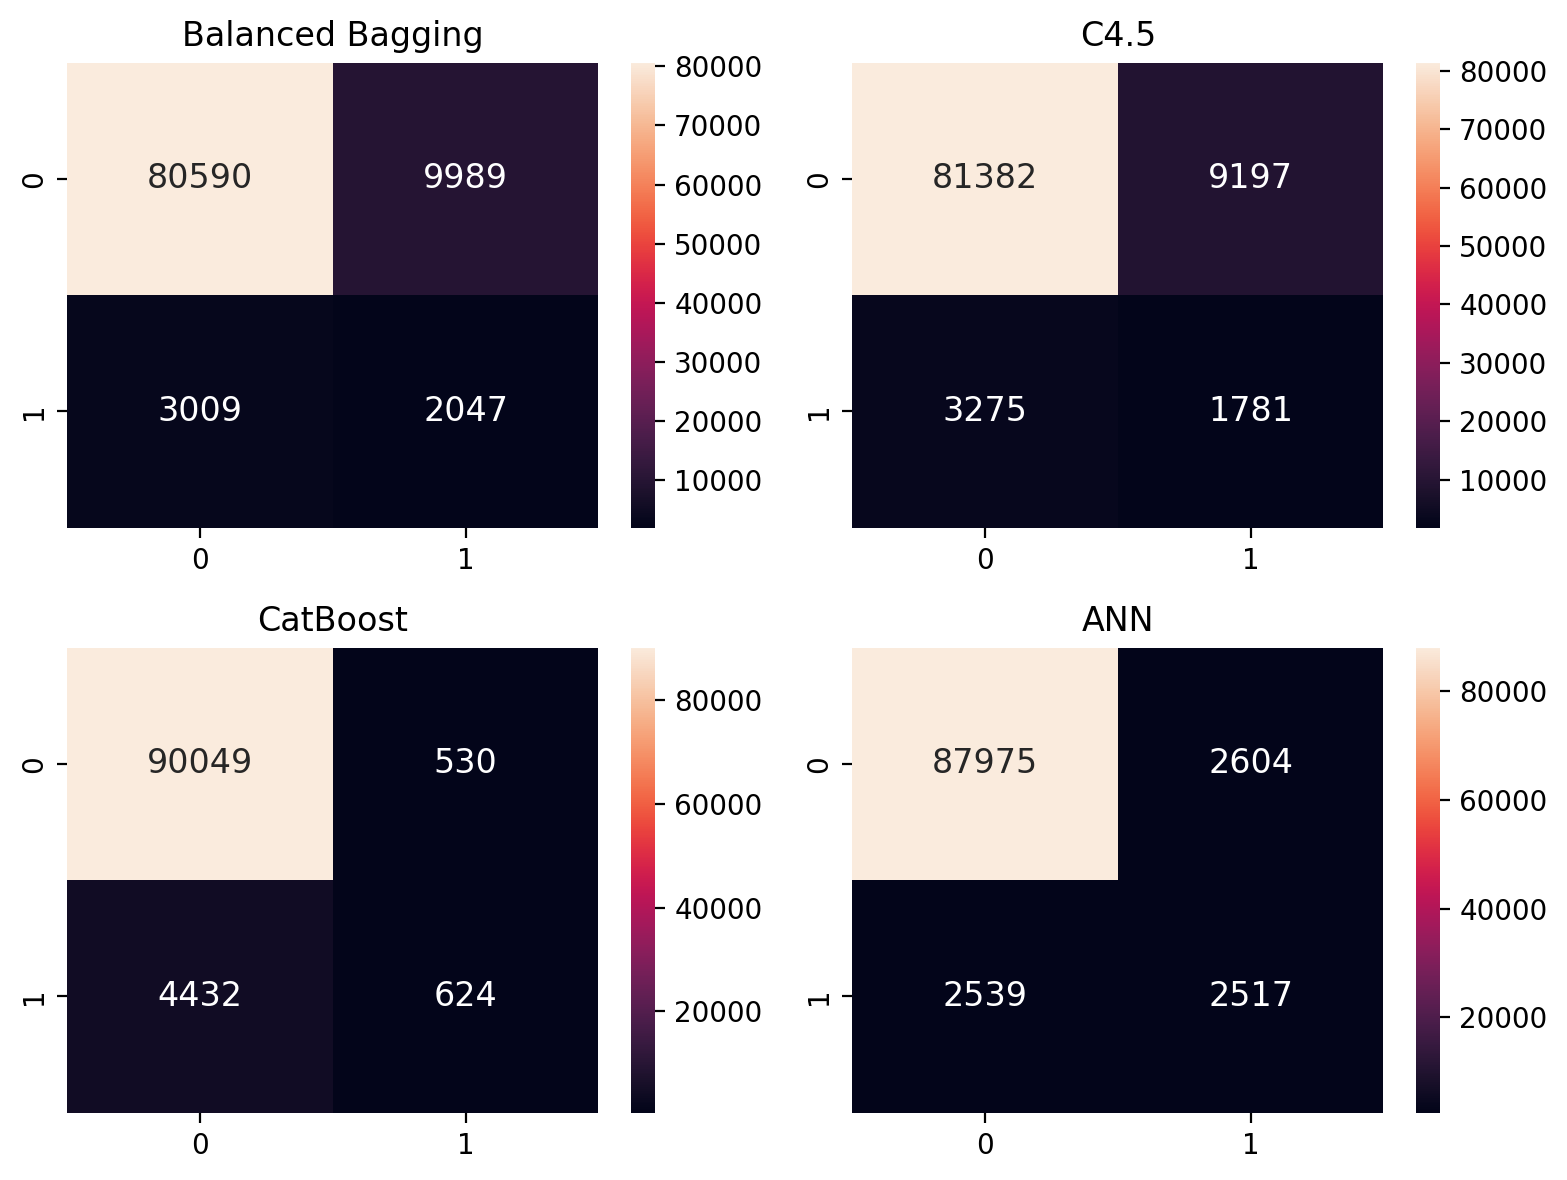

In [44]:
fig = plt.figure(figsize=(8,6),dpi=200)
for i in range(len(cms_test)):
    plt.subplot(2,2,i+1)
    sns.heatmap(cms_test[i], annot=True,annot_kws={"size":12},fmt='.0f')
    plt.title(models_name_test[i])
plt.tight_layout()
fig_name='figura_cm_test.png'
plt.savefig(path+'/figuras/%s'%fig_name,dpi=300,facecolor='white',bbox_inches='tight')

Se observa que, en general la ANN predice mejor la variable objetivo, acertando los verdaderos positivos en casi la mitad de las ocasiones, y equivocandose tanto en los falsos positivos como en los falsos negativos un número muy cercano al de verdaderos positivos. Balanced Bagging es el segundo modelo que mejor acierta los verdaderos positivos, pero equivocandose con muchos falsos positivos. Lo mimso sucede con C4.5 que fue el tercer modelo con más aciertos de verdaderos positivos. Por último, si bien CatBoost tiene muy pocos falsos negativos, tiene un pésimo desempeño en acertar los verdaderos positivos.

#### Evaluación de resultados usando un periodo de interés.
Se usan dos estaciones y dos periodos de interés,  para comparar los resultados predecidos con la variable objetivo y analizar el comportamiento obtenido.

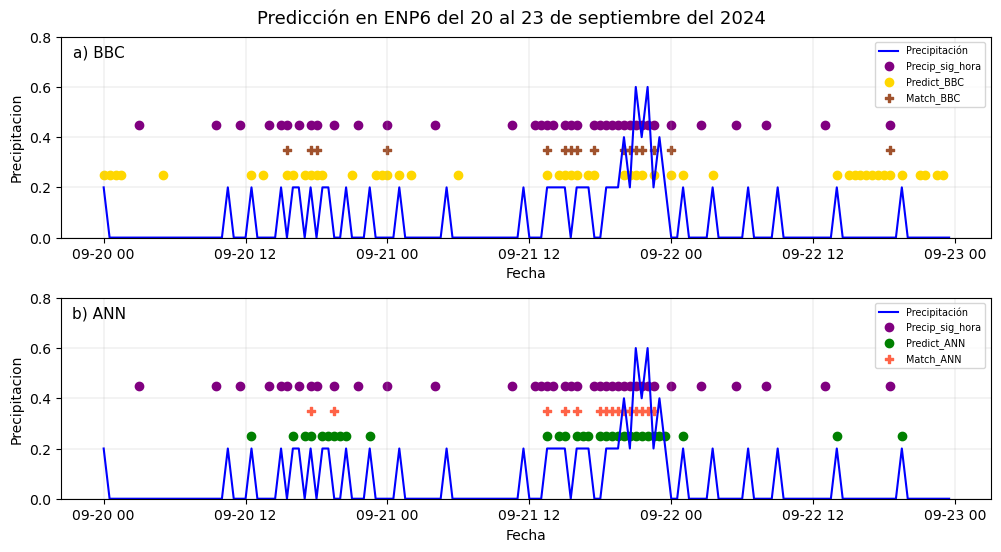

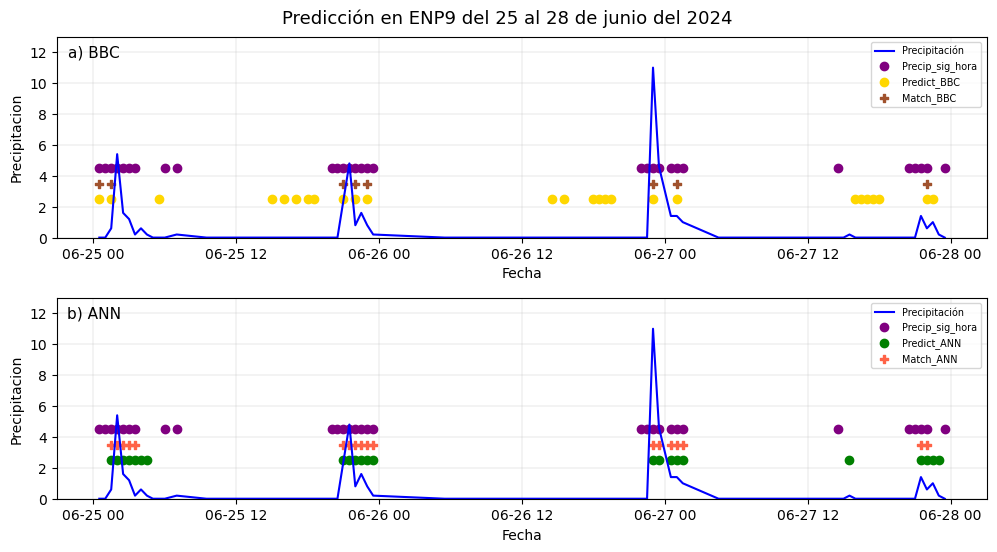

In [45]:
#variables pa usar en la graficacion
dia=[[19,23],[24,28]]
mes=[9,6]
est=['ENP6','ENP9']
pos=[1,10]
meses=['enero','febrero','marzo','abril','mayo','junio','julio',\
      'agosto','septiembre','octubre','noviembre','diciembre']
models_p=['BBC','ANN']
colors=[['gold','sienna'],['green','tomato']]
ab=['a','b']


for i in range(len(est)):
    # se eligen las estaciones y periodos de interes
    var=df_test3.loc[(df_test3.Estacion==est[i]) & (df_test3.Mes == mes[i]) &\
(df_test3.Fecha_hora.dt.day>dia[i][0]) & (df_test3.Fecha_hora.dt.day<dia[i][1]),\
['Fecha_hora','Precip_sig_hora','Precipitacion']]
    
    index_var=var.index.values
    #variable objetivo
    p=var.Precip_sig_hora.values
    p2= np.where(p == 0, np.nan, np.where(p == 1, 0.45*pos[i], p))
    #prediccion balanced bagging
    pb=y_predict_model2[0][index_var]
    pb2=np.where(pb == 0, np.nan, np.where(pb == 1, 0.25 *pos[i], pb))
    #prediccion ANN
    pt=y_predict_test_ANN_all[index_var].T[0].astype(int)
    pt2=np.where(pt == 0, np.nan, np.where(pt == 1, 0.25 *pos[i], pt))

    #indices donde hizo match la predicción con la variable objetivo
    match_ann=np.where((p == 1) & (pt == 1), 0.35 * pos[i], np.nan)
    match_sl=np.where((p == 1) & (pb == 1), 0.35 * pos[i], np.nan)

    vals=[[pb2,match_sl],[pt2,match_ann]]

    # se crean graficas
    fig = plt.figure(figsize=(12,6))
    for j in range(2):
        plt.subplot(2,1,j+1)
        ax=plt.gca()
        plt.plot(var.Fecha_hora,var.Precipitacion,color='blue',label="Precipitación")
        plt.scatter(var.Fecha_hora,p2,color='purple',label="Precip_sig_hora")
        plt.scatter(var.Fecha_hora,vals[j][0],color=colors[j][0],label="Predict_%s"%models_p[j])        
        plt.scatter(var.Fecha_hora,vals[j][1],color=colors[j][1],label="Match_%s"%models_p[j],marker='P')
        plt.legend(loc=(0.875,0.65),fontsize=6.95)
        plt.xlabel("Fecha")
        plt.ylabel("Precipitacion")
        plt.ylim(0,max(var.Precipitacion.values)+(0.2*pos[i]))
        plt.grid(True,lw=0.2)
        plt.text(0.04,0.9,ab[j]+') '+models_p[j], size=11, weight='normal',ha='center',transform=ax.transAxes)

    plt.subplots_adjust(hspace=0.3)#hspace=0)
    fig.text(0.5, 0.91, 'Predicción en %s del %s al %s de %s del 2024'\
             %(est[i],dia[i][0]+1,dia[i][1],meses[mes[i]-1]), ha='center', va='center',fontsize=13)
    fig_name='figura_predict_%s.png'%(est[i])
    plt.savefig(path+'/figuras/%s'%fig_name,dpi=300,facecolor='white',bbox_inches='tight')
    plt.show()

Se observa que, en general la ANN predice mejor la variable objetivo, al predecir los verdaderos positivos sin arrojar muchos falsos postivos. En cambio el Balanced Bagging (BB) arroja muchos falsos positivos, sin tener una prediccion muy exacta de los verdaderos positivos.

A pesar de los resultados mostrados, se observa que ambos modelos no predicen bien el cambio de estado de no lluvia a lluvia. Posiblemente los modelos estan sesgados a acertar principalmente cuando hay lluvia presente, ya que es la variable que mas se relaciona a la variable objetivo.

In [46]:
y_predict_vals=y_predict_model2.copy()
y_predict_ANN_01=y_predict_test_ANN_all.T[0].astype(int)
y_predict_vals.append(y_predict_ANN_01)
y_predict_vals.append(y_test2.values)
y_predict_arr=np.array(y_predict_vals).T
col_names=models_name_test.copy()
col_names.append("y_test2")
df_predict_test_vals = pd.DataFrame(y_predict_arr,columns=col_names)
p_name='y_predict_test_models.csv'
df_predict_test_vals.to_csv(path+'/results/'+p_name,index=False)

## Conclusiones

Para predecir la variable objetivo "Lluvia la siguiente hora" se llevaron a cabo un serie de pasos que consistieron en la limpieza de datos, un análisis exploratorio, aumento de características, y la implementación de modelos de clasificacion de SL y DL de los conjuntos de entrenamiento y prueba.

En la limpieza de datos se encontraron muchos meses sin registros de lluvia y muchas variables con datos nulos. En el análisis exploratorio se encontraron relaciones importantes entre la precipitacion y algunas variables como la humedad relativa y la rapidez del viento. Muchas de las caracteristicas creadas mostraron correlacion con la variable objetivo, permiteiendo tener una clasifiacion más precisa de los modelos. 

En la etapa de entrenamiento, con base en la métrica de recall, los modelos de SL que mejor se desempeñaron fueron Balanced Bagging y C4.5, con el costo de predecir muchos falsos positivos. Los demás modelos de SL tuvieron un mal desempeño, prediciéndo muy pobremente los verdaderos positivos. En cambio la red neuronal artifical (ANN) tuvo un mejor balance en su clasificacion, encontrando el mayor número de verdaderos positivos sin predecir tantos falsos negativos ni falsos positivos, a diferencia de los modelos de SL.

En la etapa de prueba, se encontró que la ANN es el modelo que mejor predice la variable objetivo, prediciendo cerca de la mitad de los verdaderos positivos. De SL, se observo que Balanced Bagging es el modelo que hace la mejor predicción, con el costo de encontrar muchos falsos positivos. Se concluye que para predecir la lluvia a una hora, el modelo más adecuado es una ANN.

A pesar del buen rendimiento de los modelos antes mencionados, ninguno logró predecir de manera correcta los cambios de estado de no lluvia a lluvia. Probablemente se requieren de más variables meteorologicas (como la nubosidad o visibilidad) para predecir mejor el cambio de estado. Usar un enfoque multimodal tambien permitiría predecir de forma más exacta la variable objetivo "lluvia la siguiente hora", usando como entrada datos de estaciones meteroloógicas, imagenes satelitales y de radar.  Otro factor que pudo influenciar en no conseguir una prediccion más certera es la calidad de los datos, ya que se tuvo que hacer mucha limpieza de datos.